In part 2 we prepared the data to pass through a machine learning model in various ways.  Features with too many missing data were eliminated and any missing data in the remaining variables was imputed.  Some features that were very highly correlated with others were eliminated from the data set.  To reduce the number of features and avoid colinearity the data was standardized and compressed into principal components using PCA.  Finally, we split the data into training and testing sets for model validation purposes using a stratified approach to account for the class imbalance.

In this section we will develop methods to build and validate our logistic regression model as well as perform feature optimization.  This will culminate in a model that we can apply to the 2018 data to predict the winner of the world series

In [295]:
%%capture
%run Baseball_Project_Part_2.ipynb
import warnings
warnings.filterwarnings('ignore')

The first task will be to instantiate a logistic regression model.  We will take advantage of the class_weight attribute of the model which places weights on each row entry inversely proportional to the frequency of the class in the data set.  This will help elevate the influence of the minority class in generating the model and account for the class imbalance in our data set.

Next, we will train the model using the pca transformed data and the corresponding class labels and predict (using a hold out set from the training data) whether or not a given team will win the world series.  Performing model validation on a hold out set allows us to assess the model since we already have class labels for the hold out set and we can compare the actual class labels with the predicted class labels from the model.  

The metrics we use to assess model performance need to take into account the class imbalance in our data set.  If we simply choose the default 'accuracy' that most models use as a scorer any model that simply labels each instance as the majority class (in this case not winning the world series) will receive excellent scores.  Instead we will choose to assess and optimize the model using a balanced accuracy score, cohen's kappa score, and the F1 score, all of which provide a more realistic measure of model performance when dealing with class imbalance.

The following function accepts a trained model and hold out data and generates graphical and metric outputs to evaluate model performance based on the principles discussed previously.

In [296]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced', random_state = 42, solver = 'liblinear')

lr.fit(x_train_pca, y_train)
y_pred = lr.predict(x_test_pca)

def model_evaluation(trained_model, x_test, y_test):
    from sklearn.metrics import balanced_accuracy_score, confusion_matrix, cohen_kappa_score, f1_score, roc_curve, auc
    import seaborn as sns
    sns.set()
    
    y_pred = trained_model.predict(x_test)
    y_probs = trained_model.predict_proba(x_test)
    y_probs = y_probs[:,1]

    st_probs = [0 for num in range(len(y_test))]
    
    print("Balanced Accuracy: {:.3f}".format(balanced_accuracy_score(y_test, y_pred)))
    print("Cohen's Kappa Score: {:.3f}".format(cohen_kappa_score(y_test, y_pred)))
    print("f1_score: {:.3f}".format(f1_score(y_test, y_pred)))

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, annot = True, fmt = 'g', square = True, cmap = 'Blues');
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    st_fpr, st_tpr, st_thr = roc_curve(y_test, st_probs)
    lr_fpr, lr_tpr, lr_thr = roc_curve(y_test, y_probs)
    
    roc_auc = auc(lr_fpr, lr_tpr)
    
    plt.figure()
    plt.plot(st_fpr, st_tpr, '--', label = "No Model")
    plt.plot(lr_fpr, lr_tpr, label = "Logistic Regression\n(AUC = {:.3f})".format(roc_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

Balanced Accuracy: 0.674
Cohen's Kappa Score: 0.109
f1_score: 0.154


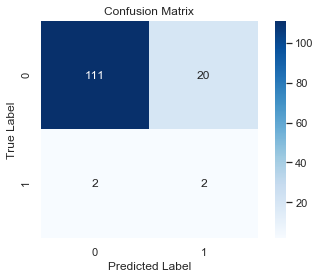

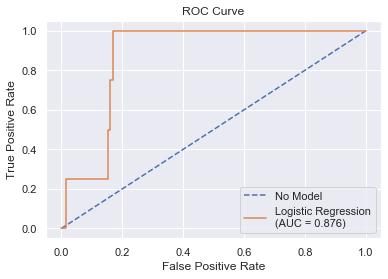

In [297]:
model_evaluation(lr, x_test_pca, y_test)

Our inital model results in an F1 score of 0.154.  From the confusion matrix we can see that the majority of errors were false positives (teams predicted to win the world series when they in fact did not). The area under the ROC curve is 0.876.  This initial result is respectable, but we may improve on the model by optimizing the hyperparameters.  We can do this using sklearn's validation curve method, which can build and evaluate several models, sweeping a given hyperparameter.  From this we can decide the optimal hyperparameter input which results in the greatest validation score and also plot validation curves to see how increasing model complexity impacts performance.

We will use the validation curve method to sweep over input values of 'C' for the logistic regression model.  This input controls the strength of the model's 'penalty', which in this case is applied via ridge regression.

In [298]:
from sklearn.model_selection import StratifiedKFold, validation_curve
from sklearn.pipeline import make_pipeline
stand_scale = StandardScaler()
pca_ = PCA(n_components = .90, svd_solver = 'full', random_state = 42)
log_reg = LogisticRegression(class_weight = 'balanced', random_state = 42, solver = 'liblinear')
skf = StratifiedKFold(n_splits = 5)
pipe = make_pipeline(stand_scale, pca_, log_reg)

train_scores, test_scores = validation_curve(pipe, pared_full_data, WSWin, param_name = 'logisticregression__C',
                                             param_range = np.arange(0.001, 3, .01), cv = skf, scoring = 'f1')

In [299]:
def plot_val_curves(train_score, test_score, param_values, param_name):

    train_score_avg = np.mean(train_score, axis = 1)
    train_score_sem = np.std(train_score, axis = 1)/np.sqrt(train_score.shape[0])
    test_score_avg = np.mean(test_score, axis = 1)
    test_score_sem = np.mean(test_score, axis =1)/np.sqrt(test_score.shape[0])
    
    fig = plt.figure()
    ax = plt.axes()

    ax.plot(param_values, train_score_avg, "-k", label = "Training Score");
    ax.fill_between(param_values, train_score_avg + train_score_sem, train_score_avg - train_score_sem)
    ax.plot(param_values, test_score_avg, "-b", label = "Testing Score");
    ax.fill_between(param_values, test_score_avg + test_score_sem, test_score_avg - test_score_sem, color = 'gray', alpha = 0.2)
    ax.set_title("Validation Curve")
    ax.set_xlabel(param_name)
    ax.set_ylabel("F1 Score")
    ax.legend(loc = 'center right');

    scores = pd.Series(test_score_avg, index = param_values);
    max_score = scores.idxmax(axis = 0)
    print("Maximum Score occurs when {} = {:.3f}".format(param_name, max_score))

Maximum Score occurs when C = 0.041


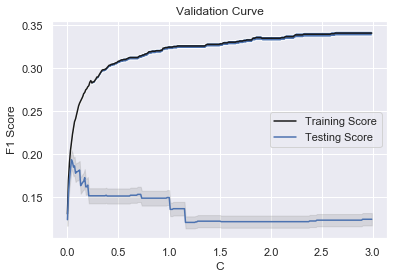

In [300]:
C = np.arange(0.001, 3, 0.01)
plot_val_curves(train_scores, test_scores, C, 'C')

The validation curve quantitative output and figure suggest that very small values of C produce the optimal model.  We can now create a new model using this optimized value of C and determine whether this change enhances the model's predictive ability.

Balanced Accuracy: 0.866
Cohen's Kappa Score: 0.140
f1_score: 0.186


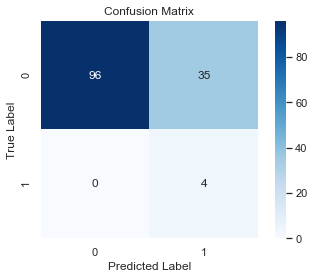

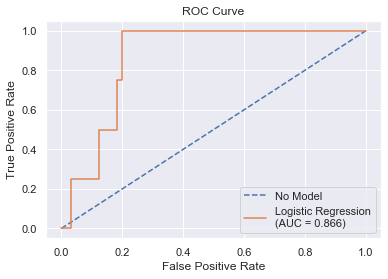

In [301]:
lr_new = LogisticRegression(class_weight = 'balanced', random_state = 42, solver = 'liblinear', C = 0.041)
lr_new.fit(x_train_pca, y_train)
y_pred_new = lr_new.predict(x_test_pca)

model_evaluation(lr_new, x_test_pca, y_test)

Building a model using 'C' = 0.041 increases the F1 score up to 0.186.  The balanced accuracy and cohen's kappa scores also are increased.  We can see from the confusion matrix that more false positive errors are made, but we completely remove the false negative errors and correctly identify 2 more world series winning teams.

To this point we have dealt with class imbalance using stratified data set splits, balanced class weighting when forming the model, and selecting criteria that provide us a better measure of model performance when dealing with imbalanced classes.  We will now implement another strategy, under sampling, to see if that can increase our model performance even further.

The imblearn package provides both under and over sampling methods that are compatible with sklearn's API.  Combining some of these methods with sklearn's pipeline and GridSearchCV functions we can test a couple different under sampling methods while also performing hyperparameter optimiziation in one go.

In [302]:
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

enn = EditedNearestNeighbours(kind_sel = 'all', random_state = 42)
rus = RandomUnderSampler(random_state = 100)
sc_us = StandardScaler()
log_reg_us = LogisticRegression(class_weight = 'balanced', random_state = 42, solver = 'liblinear')
pca_us = PCA(n_components = .90, svd_solver = 'full', random_state = 42)


In [303]:
param_grid_rus = {'logisticregression__C': np.arange(0.001, 3, .1), 'randomundersampler__sampling_strategy': np.arange(0.1, 1, 0.1)}
param_grid_enn = {'logisticregression__C': np.arange(0.001, 3, .1), 'editednearestneighbours__n_neighbors': np.arange(2, 50, 1)}

parameter_text = [('random under sampling', 'sampling_strategy'), ('edited nearest neighbors', 'n_neighbors')]
parameter_labels = ['randomundersampler__sampling_strategy', 'editednearestneighbours__n_neighbors']
params = [param_grid_rus, param_grid_enn]
models = [rus, enn]

The previous 2 cells of code instantiate the edited nearest neighbours and random under sampler methods for undersampling the majority class.  The overall goal is to remove samples from the majority class so that the imbalance between majority and minority class is not as precipitous.  Random under sampling works by randomly removing certain samples from the majority class.  Edited nearest neighbors removes samples by finding those samples in the majority class whose nearest neighbors are not all among the same class.  Both have hyperparameters that can be adjusted.  For the random under sampler we can sweep the final ratio of majority to the minority class after under sampling, and for the nearest neighbors algorithm we can sweep the number of nearest neighbors that are considered when identifying which samples to remove.  

Sklearn's GridSearchCV accepts piplines, a dictionary of hyperparameters to sweep, and a cross validation strategy to sequentially test all iterations of each model and identify which model and underlying hyperparameters result in the highest score.  Adding an undersampling component to our model pipeline means that we will also need to re-optimize the value of 'C' for the logistic regression model.  Luckily, GridSearchCV will allow us to do this as well.

In [304]:
grid_results = []

for param, model, text, label in zip(params, models, parameter_text, parameter_labels):
    
    us_pipe = make_pipeline(sc_us, pca_us, model, log_reg_us)
        
    gscv = GridSearchCV(us_pipe, param, cv = skf, scoring = 'f1')
    gscv.fit(pared_full_data, WSWin)
    
    grid_results.append(pd.DataFrame(gscv.cv_results_))
    best_params = gscv.best_params_
    
    print("\nWhen using {} the best parameters are -- {}: {}  C: {:.3f}".format(text[0], text[1], best_params[label], 
                                                                          best_params['logisticregression__C']))
    print("These parameters yield an F1 score of: {:.3f}".format(gscv.best_score_))


When using random under sampling the best parameters are -- sampling_strategy: 0.8  C: 2.601
These parameters yield an F1 score of: 0.148

When using edited nearest neighbors the best parameters are -- n_neighbors: 25  C: 2.701
These parameters yield an F1 score of: 0.203


Our results indicate the optimal under sampling method is edited nearest neighbors, when using 25 of the nearest neighbors to identify which samples to remove.  The optimal set up also corresponds to a C value of 2.701 for the logistic regression model. Using matplotlib's boxplot we can plot the F1 score output from all iterations of the grid search to visualize this

In [305]:
best_nums = {parameter_labels[0]: [0.8, 2.601], parameter_labels[1]: [25, 2.701]}
plot_array = pd.DataFrame()
x = []

for num in range(len(grid_results)):
    df = grid_results[num]
    sliced_df = df[(df['param_' + parameter_labels[num]] == best_nums[parameter_labels[num]][0]) 
                   & (df.param_logisticregression__C == best_nums[parameter_labels[num]][1])]
    
    array_add = sliced_df.loc[:, 'split0_test_score':'split4_test_score']
    array_add.index = [parameter_text[num][0]]
    plot_array = pd.concat([plot_array, array_add])
    x.append(np.ones(array_add.shape[1]) * (num + 1))

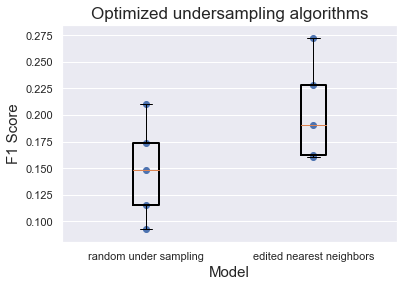

In [306]:
plt.boxplot(plot_array, labels = [parameter_text[0][0], parameter_text[1][0]], boxprops = dict([('linewidth', 2)]));
plt.scatter(x, plot_array);
plt.title("Optimized undersampling algorithms", fontdict = {'fontsize': 17, 'fontweight': 100});
plt.ylabel('F1 Score', fontsize = 15);
plt.xlabel('Model', fontsize = 15);
plt.grid(b = None, axis = 'x')

We have accounted for the class imbalance in several ways and optimized the model performance by finding the best hyperparameter values.  Now we can use the trained model to predict the winners of the 2018 world series.  To this point we have not shown the model any 2018 data, which is best practice when generating predictive machine learning models.  

Because of the high false positive error rate, we can safely assume that the model will predict more than one world series winner, even though in reality there will only be one.  At its core, the logistic regression model generates probabilities as to whether each sample belongs in a given class.  In order to assign a binary classification from a continous number betwen 0 and 1, the model will choose some probability cutoff (usually 0.5) above which the model classifies the sample as beloning to a certain class.  We can take advantage of this by inspecting probabilities instead of class labels.  

Below we graphically represent the predicted probability that a team will win the world series in the year 2018.

In [311]:
pared_data_2018.index = Teams
pred_probs = pd.DataFrame(gscv.predict_proba(pared_data_2018), index = pared_data_2018.index, 
                          columns = ['Prob_no_WS', 'Prob_WS'])

In [328]:
round_probs = pred_probs.round(3)
probs_sorted = round_probs.sort_values(by = 'Prob_WS', ascending = False)

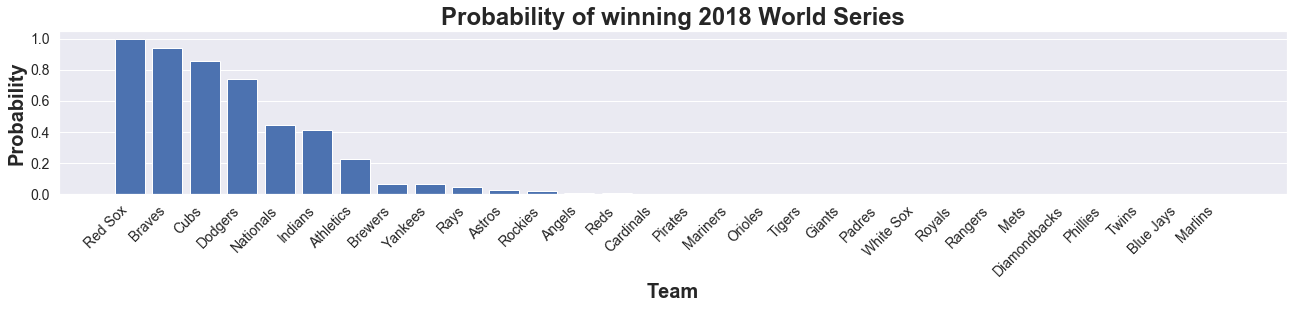

In [383]:
plt.figure(figsize = (22,3))
plt.bar(range(probs_sorted.shape[0]), probs_sorted.Prob_WS, tick_label = probs_sorted.index, align = 'center');
plt.xticks(rotation = '45', ha = 'right', fontsize = 14);
plt.yticks(fontsize = 14)
plt.grid(b = None, axis = 'x');
plt.title("Probability of winning 2018 World Series", fontsize = 24, fontweight = 800);
plt.ylabel("Probability", fontsize = 20, fontweight = 600);
plt.xlabel("Team", fontsize = 20, fontweight = 600);

Our result places the Red Sox as the most likely team to win the world series.  At the time of writing this, the 2018 world series has been completed, and the Red Sox did in fact win.  Other teams high on the list (Braves, Cubs, Dodgers, Nationals, Indians, Athletics) were all playoff teams.  Teams at the bottom of the list (Marlins, Blue Jays, Twins) were among the worst in the league in 2018.  

It seems that our model has done an admirable job predicting the winner of the world series.  However, this data is from a single predictive instance, there is no error associated with these probabilities.  In the next section we will finish the project by finding the error associated with these predictions using a bootstrapping approach.